# Characterizing and Predicting Dog Adoption Rates

## Intro
I am using data sets I obtained from Kaggle: [dog breeds parameters scraped from at dogtime.com](https://www.kaggle.com/hocop1/cat-and-dog-breeds-parameters) and the Austin Animal Center's [intake and outake records.](https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/) . 

The Austin Animal Center data describes the animals that the shelter accepts (from various places) and the dates the animal enter and leave the shelter. The time in the shelter is an important metric: it directly affects the cost of keeping the animal, and the ideal would be to have animals adopted out in a timely manner. 

I will import several python modules, load the AAC data, and clean it. I will then load a dataset of dog breed descriptions, and replace the 'breed' features, which has hundreds of breeds listed, with the breed description variables from this second data set. This will allow the use of a very descriptive feature, without expanding it into hundreds of binary features. I will then eliminate any unhelpful features, and mode the data with several machine learning models to try to estimate the time a dog will spend in the shelter.

## Setup

In [90]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import json
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox
from boruta import BorutaPy
from zipfile import ZipFile

from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

### Shelter dataset exploration and cleaning

In [2]:
raw = pd.read_csv(r'aac_intakes_outcomes.csv')  # I will used the merged file with both intake records and outcome records
shelter_inout_df = raw.copy(deep=True)

In [3]:
shelter_inout_df.animal_type.unique()

array(['Dog', 'Cat', 'Other', 'Bird'], dtype=object)

In [4]:
#we are only looking at dogs
shelter_inout_df = shelter_inout_df[shelter_inout_df.animal_type == 'Dog']

# there are a lot of features that i'm not interested, especially that describe the same thing in multiple ways. 
# I am using time in shelter as it is a simple scalar, not d datetime. 
#count is only 1, no other values exist

shelter_inout_df = shelter_inout_df.drop(columns=['animal_type', "age_upon_outcome", "animal_id_outcome", "age_upon_outcome_(years)", 
                                                  'age_upon_outcome_(days)', "age_upon_outcome_age_group", "outcome_year", 
                                                  "outcome_monthyear", "outcome_hour", "outcome_number", "animal_id_intake", 
                                                  "age_upon_intake_(years)", "age_upon_intake_age_group", "intake_year", 
                                                  "intake_monthyear", "intake_hour", "intake_number", "time_in_shelter", 
                                                  "found_location", 'outcome_datetime', 'dob_year', 'dob_month', 'dob_monthyear',
                                                  'outcome_month', 'outcome_weekday', 'age_upon_intake', 'intake_month',
                                                  'date_of_birth', 'count'])
shelter_inout_df.shape

(45366, 12)

In [5]:
shelter_inout_df.isna().sum()

outcome_subtype           31598
outcome_type                  2
sex_upon_outcome              1
breed                         0
color                         0
intake_condition              0
intake_type                   0
sex_upon_intake               1
age_upon_intake_(days)        0
intake_datetime               0
intake_weekday                0
time_in_shelter_days          0
dtype: int64

'outcome'... is the only source of nulls (at this point).

### Outcome

In [6]:
#review which outcomes have which subtypes
outcome_pivot = shelter_inout_df.pivot_table(values='breed', index='outcome_type', columns='outcome_subtype', aggfunc=len)
outcome_pivot

outcome_subtype,Aggressive,At Vet,Barn,Behavior,Court/Investigation,Enroute,Foster,In Foster,In Kennel,In Surgery,Medical,Offsite,Partner,Possible Theft,Rabies Risk,Suffering
outcome_type,,,,,,,,,,,,,,,,
Adoption,NaN,NaN,NaN,NaN,NaN,NaN,2174.0,NaN,NaN,NaN,NaN,254.0,NaN,NaN,NaN,NaN
Died,NaN,15.0,NaN,NaN,NaN,5.0,NaN,18.0,89.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
Euthanasia,492.0,12.0,NaN,133.0,23.0,NaN,NaN,NaN,NaN,NaN,61.0,NaN,NaN,NaN,86.0,690.0
Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN
Return to Owner,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transfer,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9696.0,NaN,NaN,NaN


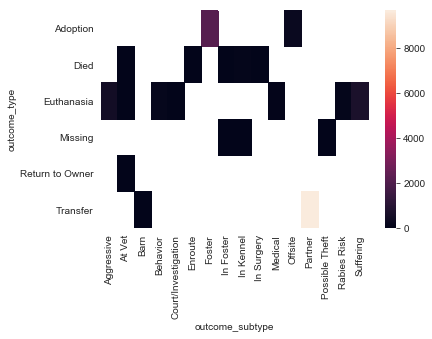

In [7]:
sns.set_style("whitegrid")
sns.heatmap(outcome_pivot);

This only contains information that is known once the animal leaves the shelter, and so can't be used to predict the time in the shelter. We might want to attempt to predict this as part of an extension of this project.

### Color 
We want to use color as a set of features. There are multiple colors listed in a text field for each animal so they need to be split and each color encoded as a variable. There will be multiple colors for some animal.

In [8]:
shelter_inout_df.color.head()

0    Yellow/White
1    Yellow/White
2    Yellow/White
3        Tricolor
4     Brown/White
Name: color, dtype: object

In [9]:
shelter_inout_df["color1"] = ""  #creating emptye columns to avoid errors when assigning to multiple columns before they are created
shelter_inout_df["color2"] = ""
shelter_inout_df["color1"] = shelter_inout_df["color"].str.split(pat="/", expand=True)[0]
shelter_inout_df["color2"] = shelter_inout_df["color"].str.split(pat="/", expand=True)[1]

In [10]:
shelter_inout_df["color_type"] = shelter_inout_df.color1.str.split(expand=True)[1]
shelter_inout_df["color1"] = shelter_inout_df.color1.str.split(expand=True)[0]
shelter_inout_df["color_type2"] = shelter_inout_df.color2.str.split(expand=True)[1]
shelter_inout_df["color2"] = shelter_inout_df.color2.str.split(expand=True)[0]

In [11]:
shelter_inout_df.color_type.unique()

array([None, 'Merle', 'Brindle', 'Tick', 'Tiger', 'Smoke', 'Cream'],
      dtype=object)

In [12]:
shelter_inout_df.color_type2.unique()

array([None, 'Brindle', 'Merle', 'Tick', 'Tiger', 'Cream', 'Tabby',
       'Smoke'], dtype=object)

In [13]:
#Investigate how many categories this variable has
pd.concat([shelter_inout_df.color1, shelter_inout_df.color2], 0).value_counts()

White        24186
Black        15704
Brown        11776
Tan           9255
Red           2623
Blue          2559
Tricolor      2454
Chocolate     1309
Gray           855
Cream          850
Sable          745
Yellow         744
Buff           666
Fawn           590
Gold           203
Silver         174
Apricot         76
Liver           72
Orange          40
Pink             4
Agouti           4
Ruddy            1
Tortie           1
dtype: int64

In [14]:
#Put values from both color fields into same set of dummy fields
color_df = pd.get_dummies(shelter_inout_df[["color1", "color2"]], drop_first=True)
color_list = pd.Series(color_df.columns.values)
color_list = pd.concat([color_list, color_list.str.split(pat='_', expand=True)], axis=1)
color_list.columns = ['fullname', 'source', 'colorname']

In [15]:
for color in color_list["colorname"].unique():
    shelter_inout_df[color] = 0
    shelter_inout_df.loc[(shelter_inout_df["color1"]==color) | (shelter_inout_df["color2"]==color),color] = 1
shelter_inout_df = shelter_inout_df.drop(columns=['color', 'color1', 'color2'])    

In [16]:
# The outcome subtypes don't seem to asking the same type of questions but they are part of the outcome and can't be used to predict
shelter_inout_df.drop(columns=["outcome_subtype"], inplace=True)

## Import the dog breed descriptions and inspect data

In [17]:
with open('rating.json', 'r') as rating_file:
    ratings = json.load(rating_file)
    json_normalize(ratings)
    dog_descr_df = pd.DataFrame.from_dict(ratings['dog_breeds'], ).T
dog_descr_df.head()

,Adaptability,All Around Friendliness,Exercise Needs,Health Grooming,Trainability,Adapts Well to Apartment Living,Affectionate with Family,Amount Of Shedding,Dog Friendly,Drooling Potential,...,Potential For Playfulness,Potential For Weight Gain,Prey Drive,Sensitivity Level,Size,Tendency To Bark Or Howl,Tolerates Being Alone,Tolerates Cold Weather,Tolerates Hot Weather,Wanderlust Potential
Affenpinscher,3.0,3.0,4.0,2.0,3.0,5.0,5.0,1.0,4.0,1.0,...,4.0,3.0,3.0,3.0,1.0,2.0,1.0,3.0,3.0,2.0
Afghan Hound,4.0,4.0,4.0,2.0,3.0,5.0,5.0,4.0,4.0,1.0,...,4.0,1.0,5.0,5.0,4.0,2.0,2.0,5.0,5.0,5.0
Airedale Terrier,2.0,4.0,5.0,3.0,5.0,1.0,4.0,2.0,4.0,1.0,...,5.0,4.0,5.0,3.0,3.0,4.0,2.0,3.0,3.0,4.0
Akita,3.0,2.0,4.0,4.0,4.0,2.0,5.0,5.0,1.0,5.0,...,5.0,4.0,4.0,5.0,4.0,5.0,1.0,5.0,2.0,4.0
Alaskan Klee Kai,3.0,3.0,4.0,3.0,4.0,3.0,4.0,4.0,2.0,2.0,...,4.0,2.0,5.0,4.0,2.0,3.0,2.0,5.0,2.0,4.0


In [18]:
dog_descr_df.describe()

,Adaptability,All Around Friendliness,Exercise Needs,Health Grooming,Trainability,Adapts Well to Apartment Living,Affectionate with Family,Amount Of Shedding,Dog Friendly,Drooling Potential,...,Potential For Playfulness,Potential For Weight Gain,Prey Drive,Sensitivity Level,Size,Tendency To Bark Or Howl,Tolerates Being Alone,Tolerates Cold Weather,Tolerates Hot Weather,Wanderlust Potential
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,...,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,3.116822,4.070093,4.107477,2.995327,3.560748,3.074766,4.700935,3.014019,3.551402,1.705607,...,4.364486,3.294393,3.593458,3.892523,2.841121,3.121495,2.037383,3.331776,3.074766,3.443925
std,0.565351,0.827771,0.818013,0.601232,0.623146,1.575642,0.560264,1.231355,1.227491,1.215034,...,0.803660,0.950545,1.201780,0.818013,1.155916,1.227313,0.953622,1.209206,0.941490,1.208008
min,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,4.000000,4.000000,3.000000,3.000000,1.000000,4.000000,2.000000,3.000000,1.000000,...,4.000000,3.000000,3.000000,3.000000,2.000000,2.000000,1.000000,3.000000,3.000000,3.000000
50%,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,5.000000,3.000000,4.000000,1.000000,...,5.000000,3.000000,4.000000,4.000000,3.000000,3.000000,2.000000,4.000000,3.000000,4.000000
75%,3.000000,5.000000,5.000000,3.000000,4.000000,5.000000,5.000000,4.000000,5.000000,2.000000,...,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000
max,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [19]:
# Make columns easier to reference in code
dog_descr_df.columns = dog_descr_df.columns.str.strip()
dog_descr_df.columns = dog_descr_df.columns.str.replace(" ", "_")

### Exercise Need - Duplicate

In [20]:
dog_descr_df.Exercise_Needs.head()

,Exercise_Needs,Exercise_Needs
Affenpinscher,4.0,3.0
Afghan Hound,4.0,4.0
Airedale Terrier,5.0,5.0
Akita,4.0,4.0
Alaskan Klee Kai,4.0,4.0


In [21]:
# Combine two features with same name but different value into one feature
exercise_need_cols = dog_descr_df.columns.get_loc("Exercise_Needs").nonzero()  # get column numbers
dog_descr_df["Exercise_Need"] = (dog_descr_df.iloc[:,[exercise_need_cols[0][0]]] + \
                                 dog_descr_df.iloc[:,[exercise_need_cols[0][1]]])/2
dog_descr_df = dog_descr_df.drop(columns=["Exercise_Needs"])  # New col is not plural
dog_descr_df.loc[:,dog_descr_df.columns.str.contains("Exer*")].head()

,Exercise_Need
Affenpinscher,3.5
Afghan Hound,4.0
Airedale Terrier,5.0
Akita,4.0
Alaskan Klee Kai,4.0


## Look for Nulls

In [22]:
dog_descr_df[dog_descr_df.isna().any(axis=1)]

,Adaptability,All_Around_Friendliness,Health_Grooming,Trainability,Adapts_Well_to_Apartment_Living,Affectionate_with_Family,Amount_Of_Shedding,Dog_Friendly,Drooling_Potential,Easy_To_Groom,...,Potential_For_Weight_Gain,Prey_Drive,Sensitivity_Level,Size,Tendency_To_Bark_Or_Howl,Tolerates_Being_Alone,Tolerates_Cold_Weather,Tolerates_Hot_Weather,Wanderlust_Potential,Exercise_Need
Korean Jindo Dog,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Xoloitzcuintli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# two rows of just null. These are not helpful.
dog_descr_df = dog_descr_df.dropna(axis=0)

## Feature Selection
Before merging these feature into the main dataframe, lets make sure they will all be helpful; highly correlated features won't add anything after the first one.

In [24]:
dog_desc_corr_df = dog_descr_df.corr()

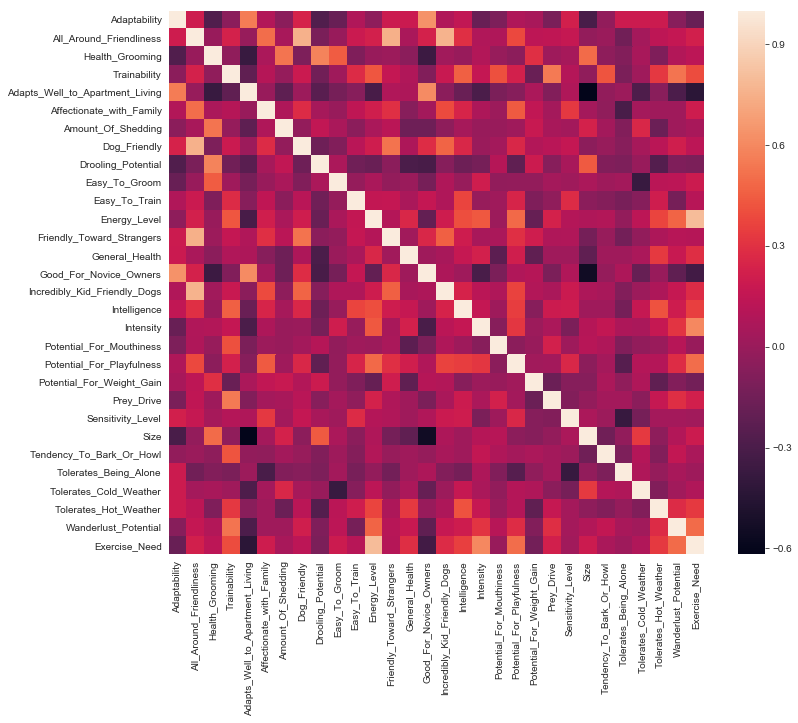

In [25]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,10))
sns.heatmap(dog_desc_corr_df);

In [26]:
#id and remove highly correlated traits to avoid multicolinearity issues in linear reg. models
dog_high_corr = dog_desc_corr_df[(dog_desc_corr_df.abs() > .65) & ~(dog_desc_corr_df == 1)]
for i, row in dog_high_corr.iterrows():
    if row.sum() > 0: 
        print("{} is correlated with: ".format(i), end = '') 
        for ind, col in row.iteritems():
            if ~np.isnan(col):
                print("{} at {}".format(ind, col))
        print("\n")


All_Around_Friendliness is correlated with: Dog_Friendly at 0.7565146009482395
Friendly_Toward_Strangers at 0.7509267951607245
Incredibly_Kid_Friendly_Dogs at 0.7605389789255196


Dog_Friendly is correlated with: All_Around_Friendliness at 0.7565146009482395


Energy_Level is correlated with: Exercise_Need at 0.8029938934844397


Friendly_Toward_Strangers is correlated with: All_Around_Friendliness at 0.7509267951607245


Incredibly_Kid_Friendly_Dogs is correlated with: All_Around_Friendliness at 0.7605389789255196


Exercise_Need is correlated with: Energy_Level at 0.8029938934844397




In [27]:
#These are highly correlated.
dog_descr_df = dog_descr_df.drop(columns=["Friendly_Toward_Strangers", "Incredibly_Kid_Friendly_Dogs", "Dog_Friendly", "Intensity",
                                         "Exercise_Need"])

## Feature Augmentation - Combining datasets

I will use the numerical features describing breeds to replace an important but difficult to use feature on the main dataset (dog breed) with a set of ordered numerical features. 


In [28]:
pd.set_option('display.max_columns', 500)
pd.set_option('max_rows', 100)

In [29]:
shelter_inout_df.shape

(45366, 34)

In [30]:
shelter_inout_df.breed.value_counts().sort_values(ascending=False).head()

Pit Bull Mix                 6256
Chihuahua Shorthair Mix      4831
Labrador Retriever Mix       4789
German Shepherd Mix          1950
Australian Cattle Dog Mix    1099
Name: breed, dtype: int64

### Breed Field Cleaning
The breed field from the shelter data has a lot of mixes and multiple breeds listed. Lets clean that.

In [31]:
shelter_inout_df.breed = shelter_inout_df.breed.str.strip()
#Breed name shouldn't be split
shelter_inout_df.breed = shelter_inout_df.breed.str.replace(r'Black/Tan', 'Black and Tan', regex=False)

shelter_inout_df.breed = shelter_inout_df.breed.str.replace(r'(Miniature |Toy |Standard )?Poodle(?=(?:$)|[$\n \/])', 'Poodle',
                                                            regex=True)  # Not sure if should add a feature for poodle type

In [32]:
def replace_abbr(col, old, new, avoid):
    search_string = r'{}(?=(?:$)|[\n \/])(?!{})'.format(old, avoid) #match old, then nl space or slash, but not avoid
    new_col = col.str.replace(search_string, new, regex=True)
    return new_col

In [33]:
# define breed name changes - Need to match breed dataframe
# Pattern is MATCH, REPLACEMENT, AVOID_REPLACING
breed_abbr_fixes = [['Terr', 'Terrier', 'ier'],  # added 'ier' to avoid null in lookahead. Not sure why this works.
                   ['Eng', 'English', ''],
                   ['Port', 'Portuguese', ''],
                   ['Span', 'Spaniel', ''],
                   ['Pinsch', 'Pinscher', 'er'],  #null in neg lookahead seems to cause problem without 'er'
                   ['Catahoula', 'Catahoula Leopard Dog', ' Leopard Dog'],
                   ['Rhod', 'Rhodesian', 'Rhod'],
                   ['Pit Bull', 'American Pit Bull Terrier', ' Terrier'],
                   ['Anatol Shepherd', 'Anatolian Shepherd Dog', ' Dog'],
                   ['German Shepherd', 'German Shepherd Dog', ' Dog'],
                   ['Black and Tan Hound', 'Black and Tan Coonhound', 'Coon']]
for i in breed_abbr_fixes:
    uncorrected, corrected, avoid = i
    shelter_inout_df.breed = replace_abbr(shelter_inout_df.breed, uncorrected, corrected, avoid)

In [34]:
#check breeds now in dataset
shelter_inout_df.breed.value_counts().sort_values(ascending=False).head()

American Pit Bull Terrier Mix    6425
Chihuahua Shorthair Mix          4831
Labrador Retriever Mix           4789
German Shepherd Dog Mix          1950
Australian Cattle Dog Mix        1099
Name: breed, dtype: int64

In [35]:
# Func to remove some common descriptors
def pull_cat_out(df, colname, category):
    df[category] = df[colname].str.contains(r'{}'.format(category), regex=True).astype(int)      
    df[colname] = df[colname].str.replace(r'{}'.format(category), '', regex=True)
    return df

In [36]:
breed_cats = ['Shorthair', 'Longhair', 'Wirehair', 'Rough Coat', 'Mix']
for cat_i in breed_cats:
    shelter_inout_df = pull_cat_out(shelter_inout_df, "breed", cat_i)

In [37]:
#reorder columns so i can see column i am using a lot
shelter_inout_df = shelter_inout_df.reindex(columns=(['breed'] + list([a for a in shelter_inout_df.columns if a != 'breed']) ))

In [38]:
shelter_inout_df.breed = shelter_inout_df.breed.str.strip()

In [39]:
# get breed names x & y for x y mix
shelter_inout_df[["breed", "breed2"]] = shelter_inout_df.breed.str.split(pat="/", expand=True, n=1)

In [40]:
shelter_inout_df.breed.value_counts().sort_values(ascending=False).head()

American Pit Bull Terrier    7055
Labrador Retriever           6260
Chihuahua                    5422
German Shepherd Dog          2612
Dachshund                    1442
Name: breed, dtype: int64

In [41]:
# run again after replacing names
shelter_inout_df.breed = shelter_inout_df.breed.str.strip()
shelter_inout_df.breed2 = shelter_inout_df.breed2.str.strip()

In [42]:
#Breed names with multiple matches - just the Black/Tan. fixed in cell above now.
#NotNeeded shelter_inout_df[shelter_inout_df.breed.str.contains("/[\w\s]+/", regex=True)]["breed"]

In [43]:
#lets find which breed names exist in shelter info but not breed info df, and add add fixes to the feature above
#This was useful during writing of above code
dog_descr_df.index.names = ['breed']  
shelter_dog_list_df = pd.DataFrame(pd.concat([shelter_inout_df.breed, shelter_inout_df.breed2], axis=0) \
                                   ).rename(columns={0:"breed"})
shelter_breed_list_df = pd.merge(left=shelter_dog_list_df, right=dog_descr_df, left_on='breed', right_on="breed", indicator=True,
                                  how='outer')
shelter_only_breeds_df = shelter_breed_list_df[shelter_breed_list_df._merge == 'left_only']
shelter_only_breeds_df["breed"].value_counts().sort_values(ascending=False).head()

Staffordshire        453
Plott Hound          388
Chinese Sharpei      236
Queensland Heeler    210
Collie Smooth        131
Name: breed, dtype: int64

### Combine DFs

In [44]:
#merge dataframes on cleaned breed columns
shelter_inout_wbreeds_df = pd.merge(left=shelter_inout_df, right=dog_descr_df, left_on="breed", right_index=True, how='left')

In [45]:
shelter_inout_wbreeds_df.describe()

,age_upon_intake_(days),time_in_shelter_days,Apricot,Black,Blue,Brown,Buff,Chocolate,Cream,Fawn,Gold,Gray,Liver,Orange,Red,Ruddy,Sable,Silver,Tan,Tricolor,White,Yellow,Pink,Tortie,Shorthair,Longhair,Wirehair,Rough Coat,Mix,Adaptability,All_Around_Friendliness,Health_Grooming,Trainability,Adapts_Well_to_Apartment_Living,Affectionate_with_Family,Amount_Of_Shedding,Drooling_Potential,Easy_To_Groom,Easy_To_Train,Energy_Level,General_Health,Good_For_Novice_Owners,Intelligence,Potential_For_Mouthiness,Potential_For_Playfulness,Potential_For_Weight_Gain,Prey_Drive,Sensitivity_Level,Size,Tendency_To_Bark_Or_Howl,Tolerates_Being_Alone,Tolerates_Cold_Weather,Tolerates_Hot_Weather,Wanderlust_Potential
count,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000
mean,978.326456,15.897242,0.001675,0.344752,0.056276,0.258960,0.014681,0.028832,0.018714,0.013005,0.004365,0.018781,0.001587,0.000882,0.057532,0.000022,0.016422,0.003835,0.203170,0.054071,0.531984,0.016378,0.000088,0.000022,0.140171,0.013975,0.004056,0.000794,0.770908,3.014504,4.145019,3.029966,3.705384,3.091276,4.864113,3.429499,1.587761,4.205092,4.025599,4.171809,3.077052,2.788766,4.287866,3.887913,4.590681,3.531192,3.233259,4.321009,2.732243,3.268364,1.733388,2.580591,2.925844,3.264884
std,1107.420744,44.430504,0.040896,0.475292,0.230456,0.438069,0.120272,0.167336,0.135516,0.113298,0.065921,0.135751,0.039807,0.029681,0.232859,0.004695,0.127093,0.061813,0.402362,0.226161,0.498981,0.126925,0.009390,0.004695,0.347168,0.117389,0.063557,0.028159,0.420253,0.375538,0.687946,0.717494,0.558940,1.556531,0.405888,1.202147,1.000467,1.312164,1.062906,0.871479,0.985374,1.110405,0.683013,1.144478,0.687184,1.020806,1.006814,0.731414,1.209232,0.965666,0.894145,1.183572,0.792617,1.047801
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,270.000000,2.093229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,4.000000,3.000000,3.000000,2.000000,5.000000,2.000000,1.000000,4.000000,4.000000,3.000000,2.000000,2.000000,4.000000,3.000000,4.000000,3.000000,3.000000,4.000000,1.000000,3.000000,1.000000,2.000000,3.000000,2.000000
50%,730.000000,5.064583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,4.000000,3.000000,4.000000,3.000000,5.000000,3.000000,1.000000,5.000000,4.000000,4.000000,3.000000,3.000000,4.000000,4.000000,5.000000,3.000000,3.000000,4.000000,3.000000,3.000000,1.000000,3.000000,3.000000,3.000000
75%,1460.000000,11.116667,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [46]:
#check for nulls on merged fields
shelter_inout_wbreeds_df[shelter_inout_wbreeds_df.Adaptability.notna()].shape

(42815, 65)

In [47]:
shelter_inout_wbreeds_df[shelter_inout_wbreeds_df.Adaptability.isna()].shape

(2551, 65)

### Deal with new nulls
I already know that there are no nulls in the dog desc DF, so nulls in any field from there will show all new nulls I introduced with the merge.

In [48]:
shelter_inout_wbreeds_df[shelter_inout_wbreeds_df["Affectionate_with_Family"].isna()].head()

,breed,outcome_type,sex_upon_outcome,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(days),intake_datetime,intake_weekday,time_in_shelter_days,color_type,color_type2,Apricot,Black,Blue,Brown,Buff,Chocolate,Cream,Fawn,Gold,Gray,Liver,Orange,Red,Ruddy,Sable,Silver,Tan,Tricolor,White,Yellow,Pink,Tortie,Shorthair,Longhair,Wirehair,Rough Coat,Mix,breed2,Adaptability,All_Around_Friendliness,Health_Grooming,Trainability,Adapts_Well_to_Apartment_Living,Affectionate_with_Family,Amount_Of_Shedding,Drooling_Potential,Easy_To_Groom,Easy_To_Train,Energy_Level,General_Health,Good_For_Novice_Owners,Intelligence,Potential_For_Mouthiness,Potential_For_Playfulness,Potential_For_Weight_Gain,Prey_Drive,Sensitivity_Level,Size,Tendency_To_Bark_Or_Howl,Tolerates_Being_Alone,Tolerates_Cold_Weather,Tolerates_Hot_Weather,Wanderlust_Potential
0,Spinone Italiano,Return to Owner,Neutered Male,Normal,Stray,Neutered Male,3650,2017-12-07 00:00:00,Thursday,0.588194,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Spinone Italiano,Return to Owner,Neutered Male,Normal,Public Assist,Neutered Male,2555,2014-12-19 10:21:00,Friday,1.259722,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Spinone Italiano,Return to Owner,Neutered Male,Normal,Public Assist,Neutered Male,2190,2014-03-07 14:26:00,Friday,1.113889,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,Staffordshire,Euthanasia,Spayed Female,Injured,Stray,Spayed Female,5840,2015-04-28 15:08:00,Tuesday,0.940278,None,None,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,Queensland Heeler,Euthanasia,Intact Male,Aged,Euthanasia Request,Intact Male,4745,2015-03-13 15:20:00,Friday,0.070139,Merle,None,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
#print(shelter_inout_wbreeds_df.isna().sum().to_string())

In [50]:
shelter_inout_wbreeds_df["no_breed_info"] = shelter_inout_wbreeds_df["Affectionate_with_Family"].isna().astype('int')

we have most of the records identified to dog breeds that are in the dog breed description dataset. Most of the remaining most common dog breeds are not in the set or are ambiguous (eg there are two breeds know as 'Staffordshire'. )

### Average breed data for animals with two breeds listed

In [51]:
#get data fields for breed2
field_list = dog_descr_df.columns.to_list()
shelter_inout_wbreeds_df = pd.merge(left=shelter_inout_wbreeds_df, right=dog_descr_df, left_on="breed2", right_index=True, 
                                    how='left', suffixes=('','_b2'))

In [52]:
shelter_inout_wbreeds_df["no_breed_info2"] = shelter_inout_wbreeds_df["Affectionate_with_Family_b2"].isna().astype('int')

In [53]:
# For rows with breed info in both sets, get averages.
shelter_inout_wbreeds_df["no_breed_info_total"] = shelter_inout_wbreeds_df["no_breed_info"] + shelter_inout_wbreeds_df["no_breed_info2"]
field_list_b2 = []
for field in field_list:
    shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df["no_breed_info_total"] == 0, field] = \
    (shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df["no_breed_info_total"] == 0, field] +
    shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df["no_breed_info_total"] == 0, (field + "_b2")] )/2
    field_list_b2.append(field + "_b2")


In [54]:
#for rows with only breed2 info, use that.
shelter_inout_wbreeds_df["only_breed2_info"] = shelter_inout_wbreeds_df["no_breed_info"] > shelter_inout_wbreeds_df["no_breed_info2"]
for field in field_list:
    shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df["only_breed2_info"] == 0, field] = \
    shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df["only_breed2_info"] == 0, (field + "_b2")] 
shelter_inout_wbreeds_df = shelter_inout_wbreeds_df.drop(columns=field_list_b2)    

In [55]:
# drop columns except field that indicates breed desc fields were imputed
shelter_inout_wbreeds_df.drop(columns=["only_breed2_info", "no_breed_info"], inplace=True)
shelter_inout_wbreeds_df["no_breed_info_total"] = shelter_inout_wbreeds_df.no_breed_info_total.replace(1,0)

In [56]:
#fill nulls create because breed was not found in breed desc, with column mean
for colname, col in dog_descr_df.iteritems():
    shelter_inout_wbreeds_df.loc[:,colname] = shelter_inout_wbreeds_df[[colname]].fillna(shelter_inout_wbreeds_df[colname].mean(), 
                                                                                         axis=1)

Since these nulls are all from the same breed, FancyImpute doesn't have any breed info to work on. 

### Intake Features

In [57]:
shelter_inout_wbreeds_df.pivot_table(values='breed', columns="intake_condition", index='intake_type', aggfunc=len)

intake_condition,Aged,Feral,Injured,Normal,Nursing,Other,Pregnant,Sick
intake_type,,,,,,,,
Euthanasia Request,34.0,NaN,10.0,74.0,NaN,1.0,NaN,63.0
Owner Surrender,56.0,NaN,189.0,8267.0,90.0,9.0,4.0,309.0
Public Assist,18.0,NaN,91.0,3891.0,24.0,26.0,1.0,52.0
Stray,169.0,8.0,1503.0,29328.0,471.0,59.0,27.0,592.0


In [58]:
#Both condition and type seem relevant and can't be eliminated
shelter_inout_wbreeds_df = pd.concat([shelter_inout_wbreeds_df, 
           pd.get_dummies(shelter_inout_wbreeds_df.intake_condition, drop_first=True, prefix="in_cond")], axis=1)


In [59]:
shelter_inout_wbreeds_df = pd.concat([shelter_inout_wbreeds_df, 
           pd.get_dummies(shelter_inout_wbreeds_df.intake_type, drop_first=True, prefix="in_type")], axis=1)
shelter_inout_wbreeds_df = shelter_inout_wbreeds_df.drop(columns = ['breed', 'breed2'])

# Feature Engineering


### Sex/Neutering
These two features can be divided from complicated categories to simplified ones: sex, neutered status, and if neutering occured. 
Neutering operations will take several days for the operation and recovery period.

In [60]:
shelter_inout_wbreeds_df.pivot_table(index='sex_upon_intake', columns='sex_upon_outcome', values='Adaptability', aggfunc=len)

sex_upon_outcome,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
sex_upon_intake,,,,,
Intact Female,4139.0,NaN,NaN,8656.0,NaN
Intact Male,NaN,4854.0,9978.0,NaN,NaN
Neutered Male,NaN,NaN,9452.0,NaN,NaN
Spayed Female,NaN,NaN,NaN,8045.0,NaN
Unknown,NaN,NaN,NaN,NaN,241.0


In [61]:
shelter_inout_df[shelter_inout_wbreeds_df.sex_upon_outcome.isna()]

,breed,outcome_type,sex_upon_outcome,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(days),intake_datetime,intake_weekday,time_in_shelter_days,color_type,color_type2,Apricot,Black,Blue,Brown,Buff,Chocolate,Cream,Fawn,Gold,Gray,Liver,Orange,Red,Ruddy,Sable,Silver,Tan,Tricolor,White,Yellow,Pink,Tortie,Shorthair,Longhair,Wirehair,Rough Coat,Mix,breed2
6523,Dachshund,Return to Owner,NaN,Normal,Owner Surrender,NaN,2555,2013-11-17 13:15:00,Sunday,10.122222,Merle,None,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None


In [62]:
#change nulls to 'unknown'
shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df.sex_upon_intake.isna(), 'sex_upon_intake'] = 'Unknown'
shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df.sex_upon_outcome.isna(), 'sex_upon_outcome'] = 'Unknown'

In [63]:
#Split features and assign one of two option to a feature
shelter_inout_wbreeds_df.loc[:, "neutered"] = shelter_inout_wbreeds_df.sex_upon_outcome.str.split(expand=True)[0]
shelter_inout_wbreeds_df.loc[:, "neutered"] = shelter_inout_wbreeds_df.neutered.apply(lambda x: x!='Intact').astype(int)

shelter_inout_wbreeds_df.loc[:, "male"] = shelter_inout_wbreeds_df.sex_upon_intake.str.split(expand=True)[1]
shelter_inout_wbreeds_df.loc[:, "male"] = shelter_inout_wbreeds_df.male.apply(lambda x: x=='Male').astype(int)

#use halfway value for unknowns 
shelter_inout_wbreeds_df.loc[shelter_inout_wbreeds_df.sex_upon_intake == 'Unknown',"neutered" : "male"] = .5, .5

In [64]:
def was_neutered(x):
    intake_type = x.sex_upon_intake.split()[0]
    outcome_type = x.sex_upon_outcome.split()[0]
    if intake_type == outcome_type:
        neutered = 0
    else:
        neutered = 1
    return neutered
shelter_inout_wbreeds_df['neutered_in_shelter'] = shelter_inout_wbreeds_df.apply(was_neutered, axis=1)

In [65]:
shelter_inout_wbreeds_df = shelter_inout_wbreeds_df.drop(columns=['sex_upon_outcome'])

### Datetime
The datetime variable for when animals arrive would be more useful if we look at seasons. 

In [66]:
def season_of_date(date_in):
    date = pd.to_datetime(date_in)
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'

shelter_inout_wbreeds_df["intake_season"] = shelter_inout_wbreeds_df.intake_datetime.transform(season_of_date)

In [67]:
#Change season category into useable features
shelter_inout_wbreeds_df = pd.merge(left=shelter_inout_wbreeds_df, 
                                    right=pd.get_dummies(shelter_inout_wbreeds_df.intake_season, drop_first=True), 
                            left_index=True, right_index=True, how='left')
shelter_inout_wbreeds_df = shelter_inout_wbreeds_df.drop(columns=['intake_season'])                              

In [68]:
#OHE weekday
shelter_inout_wbreeds_df = pd.concat([shelter_inout_wbreeds_df, 
                                      pd.get_dummies(shelter_inout_wbreeds_df.intake_weekday, drop_first=True)], axis=1)

## Feature Selection

### Split data

In [69]:
X = shelter_inout_wbreeds_df.loc[:, (shelter_inout_wbreeds_df.columns[shelter_inout_wbreeds_df.dtypes != 'object'].values)]\
    .drop(columns='time_in_shelter_days')
y = shelter_inout_wbreeds_df['time_in_shelter_days']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

### Look for multicolinearity

In [70]:
X_corr_ = X.corr().abs()
X_corr_filt = X_corr_[(X_corr_ > .9) & ~(X_corr_ == 1)]
for i, row in X_corr_filt.iterrows():
    if row.sum() > 0: 
        print("{} is correlated with: ".format(i), end = '') 
        for ind, col in row.iteritems():
            if ~np.isnan(col):
                print("{} at {}".format(ind, col))
        print("\n")


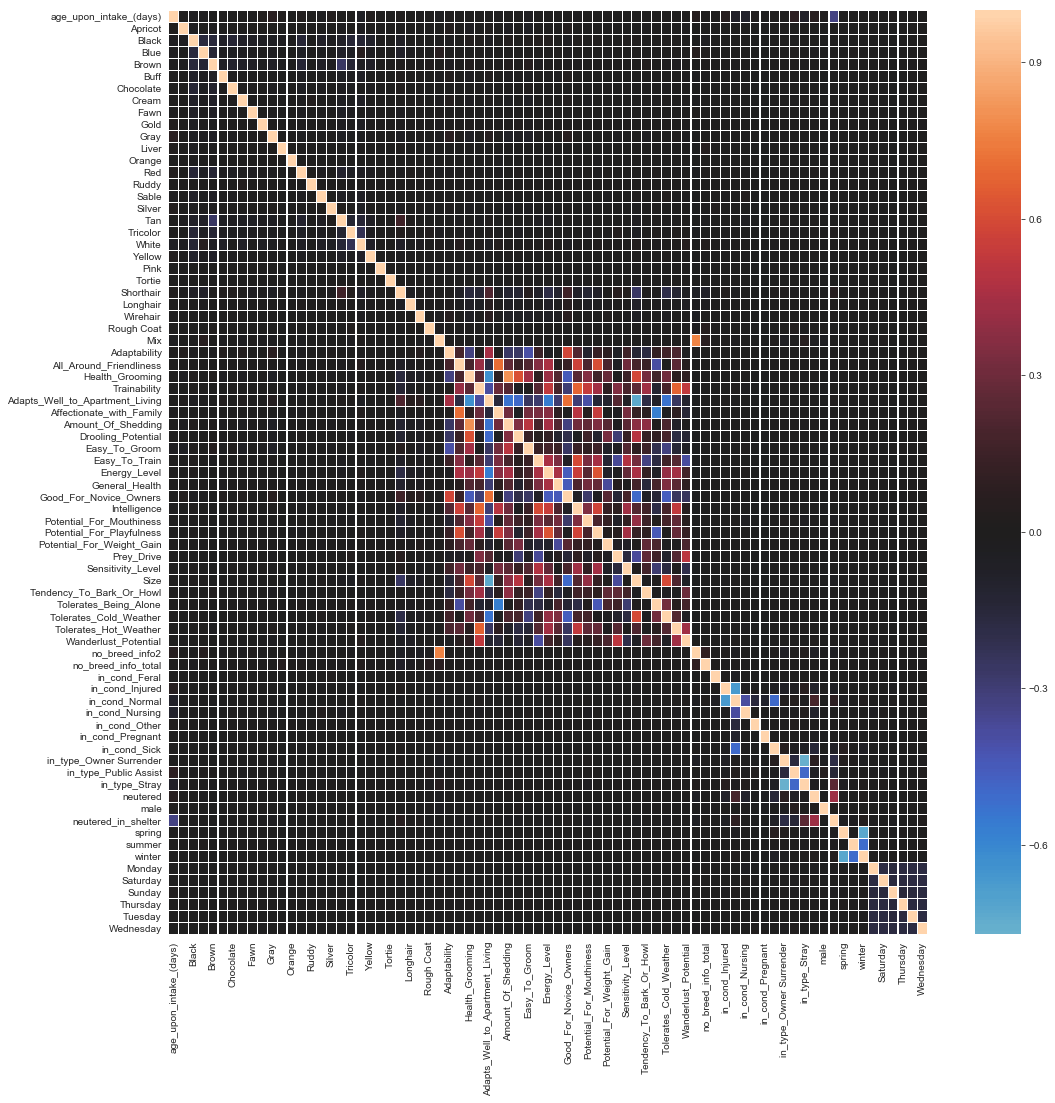

In [71]:
#look features with high correlations to multiple features
sns.set_style('darkgrid')
fig = plt.figure(figsize=(17,17))
ax = sns.heatmap(X.corr(), center=0, linewidths=.1)

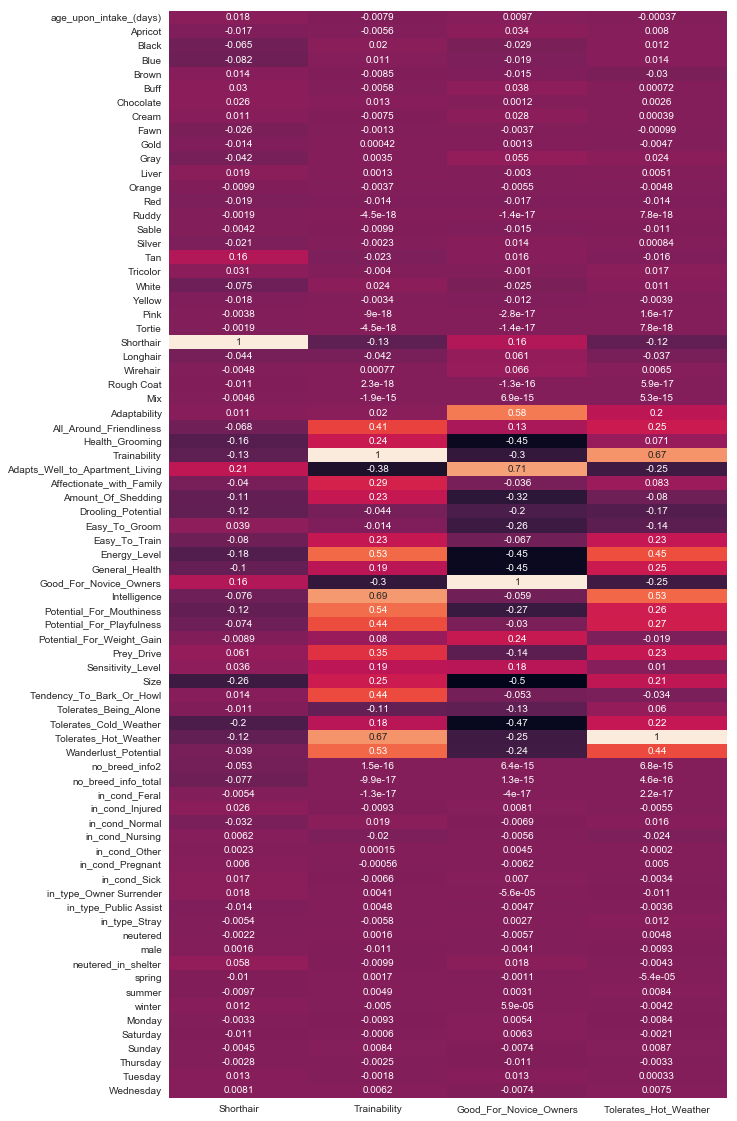

In [72]:
#Get closer look at features with potential correlation issues
plt.figure(figsize=(10,20))
sns.heatmap(annot=True, cbar=False,  data=X.corr().loc[:, X.corr().index.isin(['Shorthair', 'Trainability', 'Good_For_Novice_Owners', 'in_type_Owner_Surrender', 
                                 'Tolerates_Hot_Weather']) ]);

We could drop Shorthair but let's keep it until we do algorithmic feature selection.

### Look at variable distributions

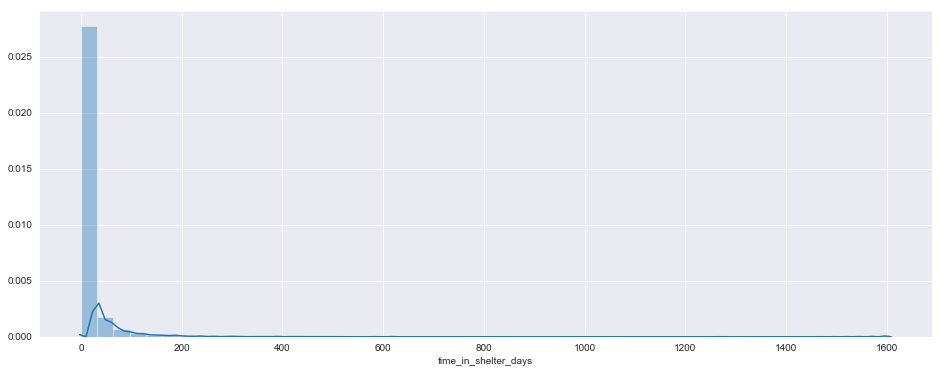

In [73]:
plt.figure(figsize=(16, 6))
sns.distplot(y_train);

In [74]:
# %load ../thinkful_notes/utility/numerical.py
#!/usr/bin/env python

# In[1]:
def winsorize(data=[], lower=5, upper=95):
    '''Winsorizes an array. Defaults are at 5 (%) and 95 (%). 
    '''
    pcts = np.percentile(data, q=[lower, upper])
    w_ized = []
    for i in data:
        if i<pcts[0]:
            w_ized.append(pcts[0])
        elif i>pcts[1]:
            w_ized.append(pcts[1])
        else: 
            w_ized.append(i)
    return w_ized

In [75]:
#There are some extreme outliers and a significant right skew. First winsorize extreme outliers
y_train = winsorize(data=y_train, lower=0, upper=99)
y_test = winsorize(data=y_test, lower=0, upper=99)  #keep data consistant

My guess is that the distribution should be a exponential? distribution; outcomes could happen each day. Let's transform this to a normal distribution. 

In [76]:
#Apply square root transform
y_train = pd.Series(y_train) + .01 # put in series so can add to each element
y_test = pd.Series(y_test) + .01
y_train = boxcox(y_train)[0]  
y_test = boxcox(y_test)[0] 

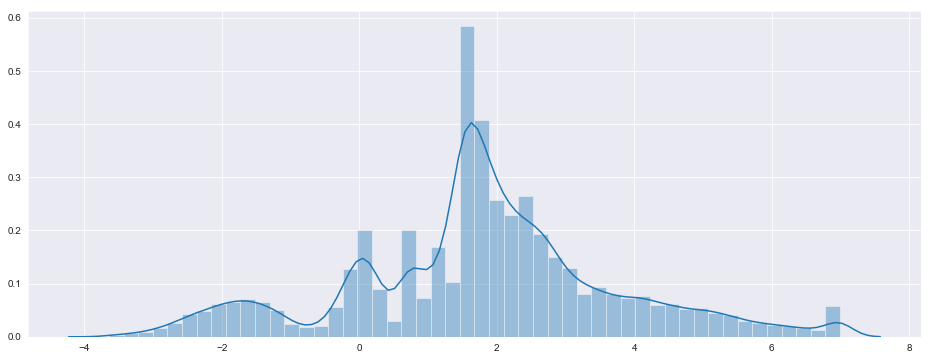

In [77]:
plt.figure(figsize=(16, 6))
sns.distplot(y_train);

This is not a normal distribution but much improved.

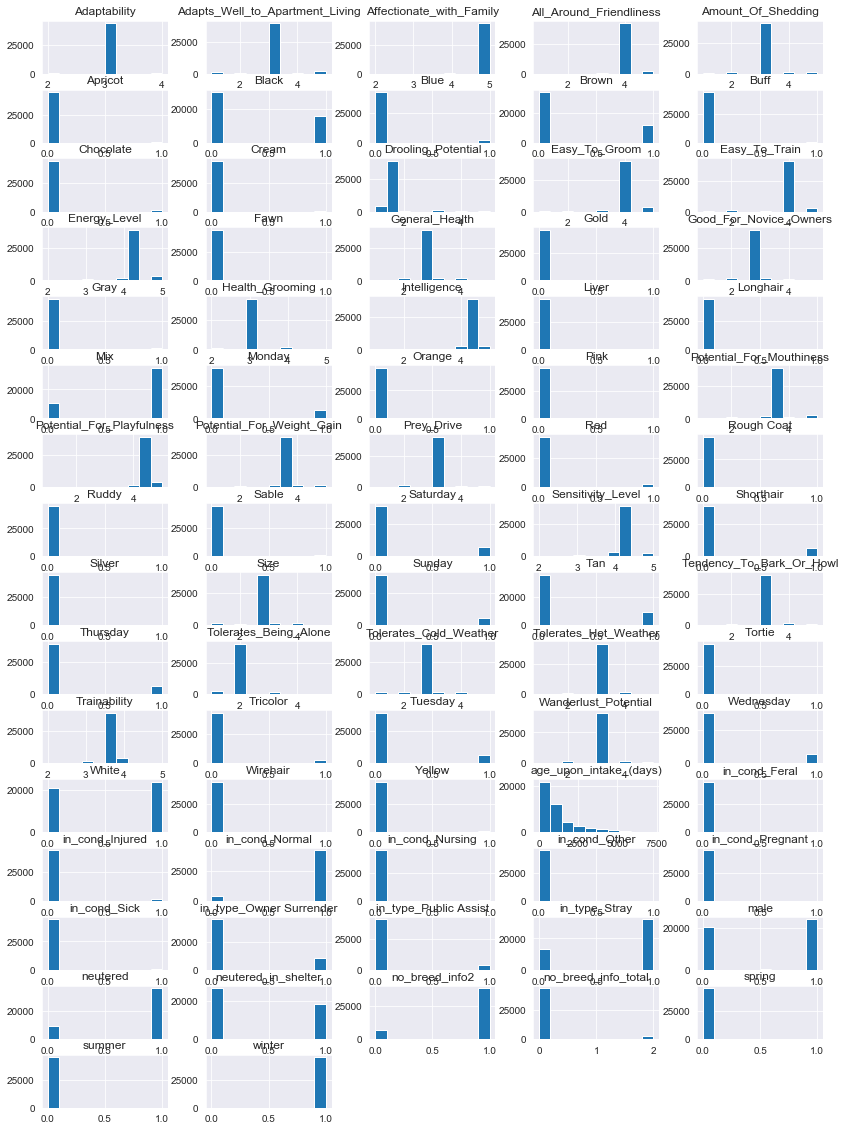

In [78]:
#Plot feature distributions
X.hist(layout=(-1,5), figsize=(14,20));    

## Feature Selection

In [79]:
X_train[X_train.isna().any(1)]

,age_upon_intake_(days),Apricot,Black,Blue,Brown,Buff,Chocolate,Cream,Fawn,Gold,Gray,Liver,Orange,Red,Ruddy,Sable,Silver,Tan,Tricolor,White,Yellow,Pink,Tortie,Shorthair,Longhair,Wirehair,Rough Coat,Mix,Adaptability,All_Around_Friendliness,Health_Grooming,Trainability,Adapts_Well_to_Apartment_Living,Affectionate_with_Family,Amount_Of_Shedding,Drooling_Potential,Easy_To_Groom,Easy_To_Train,Energy_Level,General_Health,Good_For_Novice_Owners,Intelligence,Potential_For_Mouthiness,Potential_For_Playfulness,Potential_For_Weight_Gain,Prey_Drive,Sensitivity_Level,Size,Tendency_To_Bark_Or_Howl,Tolerates_Being_Alone,Tolerates_Cold_Weather,Tolerates_Hot_Weather,Wanderlust_Potential,no_breed_info2,no_breed_info_total,in_cond_Feral,in_cond_Injured,in_cond_Normal,in_cond_Nursing,in_cond_Other,in_cond_Pregnant,in_cond_Sick,in_type_Owner Surrender,in_type_Public Assist,in_type_Stray,neutered,male,neutered_in_shelter,spring,summer,winter,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday


In [80]:
#use best hypers from search
random_forest_best = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [81]:
# use Bourta feature elimination to get alternative list of features to use
boruta_est_cnt = 30
boruta_selector_more = BorutaPy(random_forest_best, n_estimators=boruta_est_cnt, verbose=0, perc=50)
boruta_selector_more.fit(X_train.values, y_train)  #Boruta only accepts np arrays

BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                         max_depth=15, max_features='auto',
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=20,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=30, n_jobs=-1,
                                         oob_score=False,
                                         random_state=<mtrand.RandomState object at 0x0000020F7C411098>,
                                         verbose=0, warm_start=False),
         max_iter=100, n_estimators=30, perc=50,
         random_state=<mtrand.RandomState object at 0x0000020F7C411098>,
         two_

In [82]:
boruta_selector_fewer = BorutaPy(random_forest_best, n_estimators=boruta_est_cnt, verbose=0, perc=100)
boruta_selector_fewer.fit(X_train.values, y_train)  #Boruta only accepts np arrays

BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                         max_depth=15, max_features='auto',
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=20,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=30, n_jobs=-1,
                                         oob_score=False,
                                         random_state=<mtrand.RandomState object at 0x0000020F7C411098>,
                                         verbose=0, warm_start=False),
         max_iter=100, n_estimators=30, perc=100,
         random_state=<mtrand.RandomState object at 0x0000020F7C411098>,
         two

In [83]:
print("Number of features Selected by Bourta Alg: More: {}, fewer: {}"\
      .format(boruta_selector_more.n_features_, boruta_selector_fewer.n_features_))
print("Selected Features (More): {}".format(X_train.columns[boruta_selector_more.support_]))
print("Possible Features (Fewer): {}".format(X_train.columns[boruta_selector_fewer.support_]))

Number of features Selected by Bourta Alg: More: 29, fewer: 3
Selected Features (More): Index(['age_upon_intake_(days)', 'Black', 'Blue', 'Brown', 'Gray', 'Tan',
       'White', 'Shorthair', 'Adapts_Well_to_Apartment_Living',
       'Amount_Of_Shedding', 'Easy_To_Groom', 'Good_For_Novice_Owners',
       'Potential_For_Mouthiness', 'Potential_For_Weight_Gain',
       'Tolerates_Hot_Weather', 'no_breed_info_total', 'in_cond_Injured',
       'in_cond_Normal', 'in_cond_Sick', 'in_type_Owner Surrender',
       'in_type_Public Assist', 'in_type_Stray', 'neutered', 'male',
       'neutered_in_shelter', 'Monday', 'Saturday', 'Thursday', 'Wednesday'],
      dtype='object')
Possible Features (Fewer): Index(['age_upon_intake_(days)', 'in_type_Stray', 'neutered_in_shelter'], dtype='object')


In [84]:
# Create new X with reducted feature set
X_train_red = X_train.loc[:,X_train.columns[boruta_selector_more.support_]]
X_test_red = X_test.loc[:,X_test.columns[boruta_selector_more.support_]]
X_red = X.loc[:,X.columns[boruta_selector_more.support_]]
X_train_red_fewer = X_train.loc[:,X_train.columns[boruta_selector_more.support_]]
X_test_red_fewer = X_test.loc[:,X_test.columns[boruta_selector_more.support_]]

In [85]:
random_forest_best.fit(X_train_red, y_train)
random_forest_best_fewer = clone(random_forest_best)
random_forest_best_fewer.fit(X_train_red_fewer, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                      oob_score=False,
                      random_state=<mtrand.RandomState object at 0x0000020F01C36A98>,
                      verbose=0, warm_start=False)

In [86]:
rf_cv_score_more_features = cross_val_score(estimator=random_forest_best, X=X_train_red, y=y_train, cv=3, n_jobs=-1)
rf_cv_score_fewer_features = cross_val_score(estimator=random_forest_best_fewer, X=X_train_red_fewer, y=y_train, cv=3, n_jobs=-1)

print("Score with More features retained: {}".format(rf_cv_score_more_features))
print("Score with fewer features retained: {}".format(rf_cv_score_fewer_features))

Score with More features retained: [0.24523379 0.26267385 0.25852618]
Score with fewer features retained: [0.24335169 0.26145517 0.2564611 ]


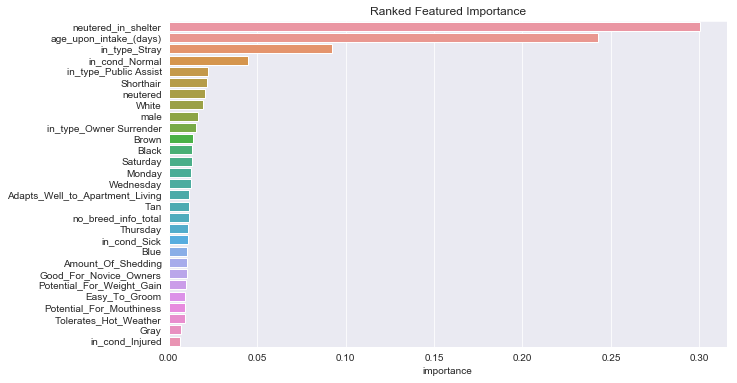

In [87]:
#review feature importance of selected features
reduced_features = X_train.columns[boruta_selector_more.support_].to_list()
important_features = pd.DataFrame(data=random_forest_best.feature_importances_, index=reduced_features)
important_features.columns = ['importance']
important_features.sort_values(by='importance', ascending=False,inplace=True)
figimp = plt.figure(figsize=(10,6))
aximp = sns.barplot(y=important_features.index, x=important_features['importance'], orient='h')
aximp.set(title='Ranked Featured Importance');

## Modeling

### Linear Regression
We will first try a linear regression since that has the advantage of speed, and explainability if it works well.  
We will use a random search to find the best hyperparameters.  
Models with regularization needs standardized data. Since most data is from OHE, we will use minmax.

In [88]:
X_red_stand =  MinMaxScaler(feature_range=(0,1)).fit_transform(X_red)

In [91]:
params = {'alpha': stats.uniform(.0001, 100),
         'l1_ratio': stats.uniform(.1, .9)}
enet = ElasticNet()
enet_rsearch = RandomizedSearchCV(estimator=enet, param_distributions=params, n_iter=12, cv=5)
#enet_rsearch.fit(X_train, y_train)
nested_scores = cross_validate(estimator=enet_rsearch, X=X_red_stand, y=y, cv=4, n_jobs=-1, return_estimator=True)
print('Test scores are: {}'.format(nested_scores['test_score']))
print('Estimator Values are: {}'.format(nested_scores['estimator']))

Test scores are: [-0.00181341  0.00122124  0.01349117 -0.05266659]
Estimator Values are: (RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=ElasticNet(alpha=1.0, copy_X=True,
                                        fit_intercept=True, l1_ratio=0.5,
                                        max_iter=1000, normalize=False,
                                        positive=False, precompute=False,
                                        random_state=None, selection='cyclic',
                                        tol=0.0001, warm_start=False),
                   iid='warn', n_iter=12, n_jobs=None,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020F032B5588>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020F0334F248>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_sc

### Forest Models
There may be a number of interactions, so forest-based modles may be useful to improve predictive ability.

In [92]:
rforest_params = {'criterion': ('mse', 'mae'),
                 'max_features': ('log2', 'sqrt', .2, .15),  
                 'max_depth': (5, 15, 30),
                 'min_samples_split': (10, 20, 30)}  

rforest = RandomForestRegressor(n_estimators=80, verbose=0, n_jobs=-1, oob_score=True, bootstrap=True)
rforest_rsearch = RandomizedSearchCV(estimator=rforest, param_distributions=rforest_params, n_iter=30, cv=3)

In [ ]:
#cross validate model
rf_cv_scores = cross_validate(estimator=rforest_rsearch, X=X_train_red, y=y_train, n_jobs=-1, return_estimator=True, cv=4)
rf_cv_scores['test_score']

In [ ]:
rf_cv_scores.best_estimator_

In [ ]:
rf_cv_scores.best_params_

In [ ]:
rforest_best = RandomForestRegressor(**rf_cv_scores.best_params_, n_estimators=120, n_jobs=-1)

In [ ]:
rforest_best.fit(X_train, y_train)

In [ ]:
gboost_params = {'loss': ('ls', 'lad', 'huber'),
                 'subsample': (.5, .8, 1),
                 'learning_rate': (.05, .08, .1, .2, .3, .6),
                 'max_depth': (2, 3, 5, 6)}
grad_boost = GradientBoostingRegressor(n_estimators=120)
grad_boost_rs = RandomizedSearchCV(estimator=grad_boost, param_distributions=gboost_params, cv=4)
gboost_cv_score = cross_val_score(estimator=grad_boost, X=X_train_red, y=y_train, n_jobs=-1, cv=4, verbose=1)

In [ ]:
gboost_cv_score
#gboost_cv_score['test_score']

### Other Models - KNN and SVM

In [ ]:
kn_params = {'n_neighbors': (3, 5, 7),
             'weights': ('uniform', 'distance'),
             'p': (1.5, 2, 2.5)}
knr = KNeighborsRegressor()
knr_rsear = RandomizedSearchCV(estimator=knr, param_distributions=kn_params, n_jobs=-1, n_iter=12, cv=3)
knr_cv_score = cross_val_score(estimator=grad_boost, X=X_red_stand, y=y, n_jobs=-1, cv=4, verbose=1)

In [ ]:
knr_cv_score

In [ ]:
svr_params = {'C': (.4, .7, 1, 1.3, 2, 10),
              'epsilon': (.001, .01, .1), 
              'kernel': ('linear', 'poly', 'rbf')}
svr = SVR()
svr_search = RandomizedSearchCV(estimator=svr, param_distributions=svr_params, n_jobs=-1, n_iter=12, cv=3)
svr_cv_score = cross_val_score(estimator=svr_search, X=X_red_stand, y=y, n_jobs=-1, cv=4, verbose=1)

In [ ]:
svr_cv_score